## HR Analytics: Job Change of Data Scientists

Данные взяты с 
https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists

#### Колонки:
enrollee_id : Unique ID for candidate

city: City code

city_ development _index : Developement index of the city (scaled)

gender: Gender of candidate

relevent_experience: Relevant experience of candidate

enrolled_university: Type of University course enrolled if any

education_level: Education level of candidate

major_discipline :Education major discipline of candidate

experience: Candidate total experience in years

company_size: No of employees in current employer's company

company_type : Type of current employer

lastnewjob: Difference in years between previous job and current job

training_hours: training hours completed

target: 0 – Not looking for job change, 1 – Looking for a job change

In [1]:
# Загрузка библиотек

import xgboost
import lightgbm

import shap

shap.initjs()

import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np

from sklearn.model_selection import train_test_split

import itertools

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
# Загрузка данных

df = pd.read_csv("aug_train.csv")

In [5]:
# Обзор данных

df.head(3)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0


In [6]:
# Удаление столбца "enrollee_id"

df.drop(["enrollee_id"], axis=1, inplace=True)

In [7]:
# Исправление названия столбца

df = df.rename(columns={"relevent_experience": "relevant_experience"})

In [8]:
# Размеры датасета

df.shape

(19158, 13)

In [9]:
# Типы данных

df.dtypes

city                       object
city_development_index    float64
gender                     object
relevant_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object

In [10]:
# Соотношение классов

df.iloc[:, -1].value_counts()

0.0    14381
1.0     4777
Name: target, dtype: int64

Датасет несбалансирован, 75% значений целевой переменной равны 0 и 25% равны 1.

### Работа с данными

In [11]:
# Проверка пропущенных значений
    
df.isna().sum()

city                         0
city_development_index       0
gender                    4508
relevant_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [12]:
# Количество уникальных значений по столбцам 

df.nunique()

city                      123
city_development_index     93
gender                      3
relevant_experience         2
enrolled_university         3
education_level             5
major_discipline            6
experience                 22
company_size                8
company_type                6
last_new_job                6
training_hours            241
target                      2
dtype: int64

Большая часть данных представлена категориальными признаками, которые нужно кодировать.

Признаки, где уникальных значений больше 4, обозначим цифрами.

Если уникальных значений признака меньше 4, используем дамми кодирование.

Некоторые признаки имеют значительное количество пропусков, заменим их модой.

Визуализируем некоторые признаки.

In [13]:
# График, отображающий количество значений признака

def value_counts_plot(column):
    counts = column.value_counts()

    plt.style.use('seaborn-pastel')

    plt.figure(figsize=(12,6))
    plt.title(column.name)
    sns.barplot(counts.index, counts.values)

    plt.show()

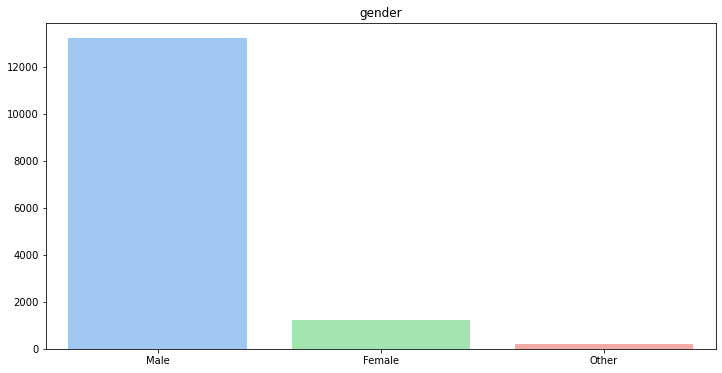

In [14]:
value_counts_plot(df["gender"])

По графику видим не только значительный перекос по значениям, но и неожиданное третье значение в поле "gender" - "other".

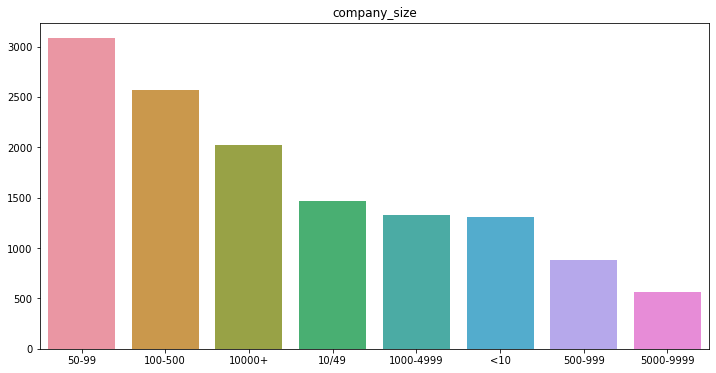

In [15]:
value_counts_plot(df["company_size"])

Имеет смысл перевести данную переменную из категориальной в количественную

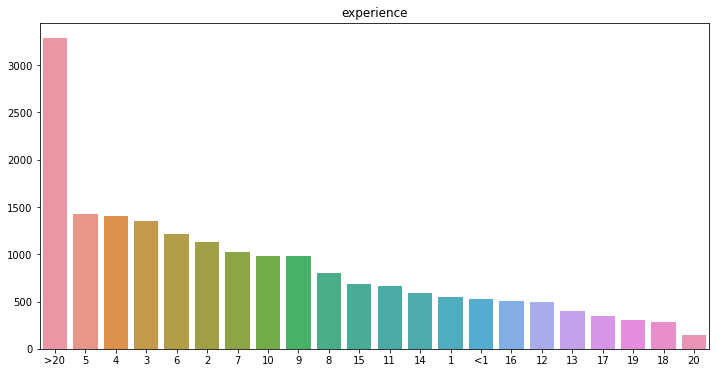

In [16]:
value_counts_plot(df["experience"])

По графику видим, что "experience" на самом деле не является категориальной переменной и требует небольшой обработки.

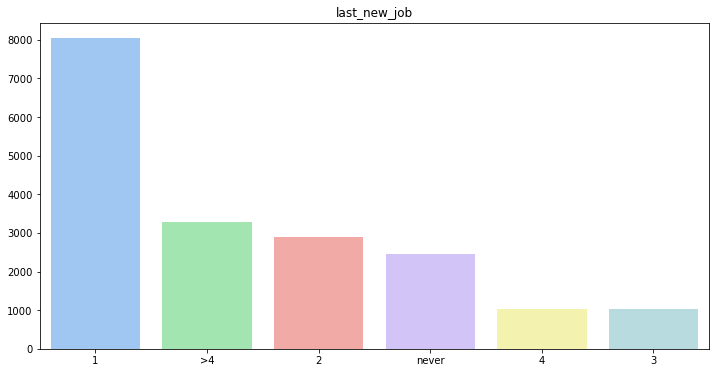

In [17]:
value_counts_plot(df["last_new_job"])

"last_new_job" тоже по сути является количественной переменной

In [18]:
# Замена типа данных "object" на "category"

object_columns = df.dtypes[df.dtypes == np.object]
object_columns_list = list(object_columns.index)

df[object_columns_list] = df[object_columns_list].astype("category")

In [19]:
# Заполнение пропущенных значений модой

nan_values = df.isna()
nan_columns = nan_values.any()

columns_with_nan = df.columns[nan_columns].tolist()

for i in columns_with_nan:
    df[i] = df[i].fillna(df[i].mode()[0])

In [20]:
# Признак "relevant_experience" имеет только два значения "Has relevent experience" и "No relevent experience"
# Заменим значения на 1|0

df["relevant_experience"].replace({"Has relevent experience": "1", "No relevent experience": "0"}, inplace=True)

df["relevant_experience"] = df["relevant_experience"].astype(int)

In [21]:
# Трансформация признака "experience"
# Заменим <1 на 0.5, >20 на 25 и преобразуем тип данных 

df["experience"].replace({"<1": "0.5", ">20": "25"}, inplace=True)

df["experience"] = df["experience"].astype(float)

In [22]:
# Трансформация признака "company_size"
# Преобразуем признак из категориального в количественный, заменим на верхнюю границу

df["company_size"].replace({"50-99": "99", "100-500": "500", "10000+": "15000", 
                           "10/49": "49", "1000-4999": "4999", "<10": "10",
                           "500-999": "999", "5000-9999": "9999"}, inplace=True)

df["company_size"] = df["company_size"].astype(int)

In [23]:
# Трансформация признака "last_new_job"
# Заменим never на 0, >4 на 5 и преобразуем тип данных 

df["last_new_job"].replace({"never": "0", ">4": "5"}, inplace=True)

df["last_new_job"] = df["last_new_job"].astype(int)

In [24]:
# Составление списка колонок, где количество уникальных значений равно 3

ohe_columns = df.nunique()[df.nunique() == 3]
ohe_columns_list = list(ohe_columns.index)
print(ohe_columns_list)

['gender', 'enrolled_university']


In [25]:
# Составление списка колонок, где количество уникальных значений больше 4

le_columns_cat = df.select_dtypes("category")
le_columns = le_columns_cat.nunique()[le_columns_cat.nunique() >= 4]
le_columns_list = list(le_columns.index)
print(le_columns_list)

['city', 'education_level', 'major_discipline', 'company_type']


In [26]:
# Дамми кодирование столбцов, где количество уникальных значений меньше 4

for i in ohe_columns_list:
    dummies = pd.get_dummies(df[i])
    df = df.drop(i,axis = 1)
    df = df.join(dummies)

In [27]:
# Кодирование переменных, где количество уникальных значений больше 4

for i in le_columns_list:
    df[i] = df[i].cat.codes 

In [28]:
# Обновленный датасет

df.head(3)

,city,city_development_index,relevant_experience,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target,Female,Male,Other,Full time course,Part time course,no_enrollment
0,5,0.920,1,0,5,25.0,99,5,1,36,1.0,0,1,0,0,0,1
1,77,0.776,0,0,5,15.0,99,5,5,47,0.0,0,1,0,0,0,1
2,64,0.624,0,0,5,5.0,99,5,0,83,0.0,0,1,0,1,0,0


In [29]:
# Разделение на тренировочную и тестовую выборки

features = list(df.columns)
features.remove("target")

X_train, X_test, y_train, y_test = train_test_split(df[features], df["target"], test_size=0.3, random_state=17)

### SHAP

In [30]:
# Обучение модели

model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X_train, label=y_train), 100)

In [31]:
explainer = shap.TreeExplainer(model)

In [32]:
shap_values = explainer.shap_values(X_train)

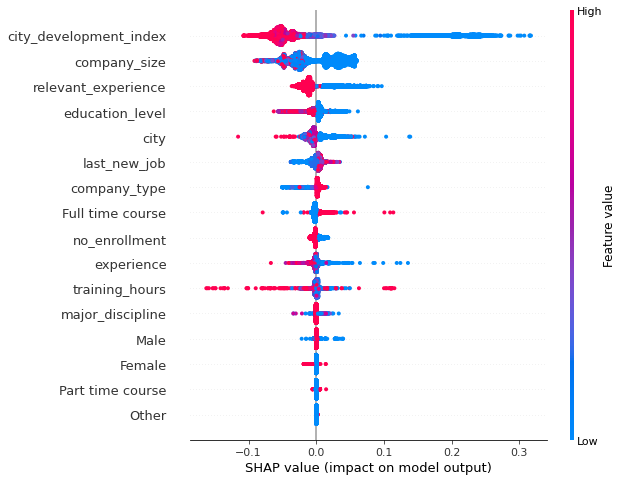

In [33]:
# Влияние признаков на целевую переменную

shap.summary_plot(shap_values, X_train)

Как мы видим, самое большое влияние оказывает "city_development_index", что довольно неожиданно, потому что не имеет прямого отношения к таргетной переменной. 

Чем выше показатели: city_development_index, relevant_experience, education_level, experience, training_hours, тем тем больше шансов, что наблюдение будет принадлежать к классу 0 (не ищет новую работу).

Чем ниже показатели: company_type, last_new_job, тем тем больше шансов, что наблюдение будет принадлежать к классу 1 (ищет новую работу).

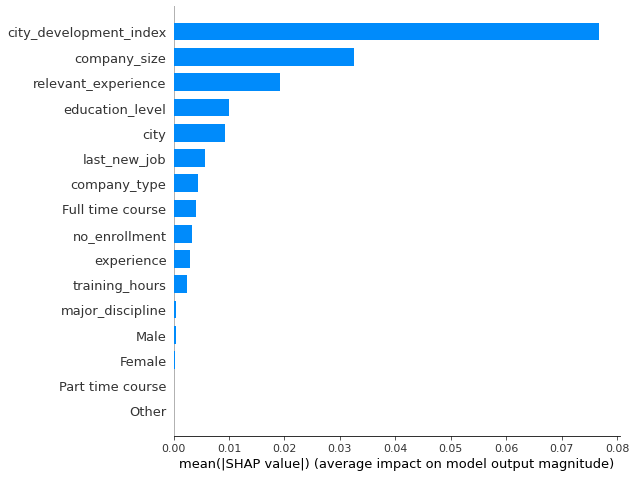

In [34]:
# Значимость признака

shap.summary_plot(shap_values, X_train, plot_type="bar")

In [35]:
# Влияние факторов для отдельного наблюдения

shap.force_plot(explainer.expected_value, shap_values[1,:], X_train.iloc[1,:])

Предсказанная вероятность равна 0.52. 

Факторы, оказывающие влияние: 
- увеличивают вероятность отнесения к классу 1: размер компании (небольшая), соответствующий опыт (отсутствует), уровень развития города (чуть выше среднего),
- увеличивают вероятность отнесения к классу 0: количество лет опыта (17 лет), время со смены места работы (0).

In [36]:
# Влияние факторов для отдельного наблюдения

shap.force_plot(explainer.expected_value, shap_values[17,:], X_train.iloc[17,:])

Предсказанная вероятность равна 0.22. 

Факторы, оказывающие влияние: 
- увеличивают вероятность отнесения к классу 1: время со смены места работы (5 лет), 
- увеличивают вероятность отнесения к классу 0: уровень развития города (высокий), размер компании (маленькая), соответствующий опыт (есть), количество лет опыта (25 лет), город.